# Univariate methods

Univariate methods take only one feature into consideration when splitting the node into leafs. In this section we cover two univariate methods:
- CART,
- C4.5.

There are more univariate methods, but show only two examples that use different split methods. In this notebook we show two methods with a different approach to splitting. The first one build a binary tree and the second generates a non-binary tree.

In [105]:
import math
import numpy as np
import pydot
import copy
from math import log

We should restore the ``data_set`` and ``labels`` from the previous notebook.

In [106]:
data_set = None
labels = None
%store -r data_set
%store -r labels

## CART

CART stands for Classification and Regression Trees. It generates a binary tree and consist of three steps:
1. Calculate the gini index for each feature
2. Take the lowest value ofωand split the node into two child nodes
3. Repeat the steps until we have all child nodes

Before we come to the method itself, we should define the leaf.

In [107]:
class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.elements = elements
        self.split_feature = None
        self.labels = labels
        self.completed = False
        self.ids = ids

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_split(self, feature):
        self.split_feature = feature

    def get_split(self):
        return self.split_feature

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids

The variables that we gonna use is the ``labels_count``, in other words the number of classes. We need ``ids`` to track the split. 

In [108]:
print(labels)
labels_count = len(np.unique(labels))
print(labels_count)

ids = list(range(len(data_set)))
print(ids)
root = BinaryLeaf(data_set, labels, ids)
current_node = root

[1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


There are several helper functions that are next used by our CART method. We use the methods to:
- ``get_unique_labels`` - return the unique labels in a leaf,
- ``get_unique_values`` - return unique values in a leaf,
- ``is_leaf_completed`` - check if a leaf needs to be split or not,
- ``find_leaf_not_completed`` - returns the leaf that needs to be split.

In [109]:
def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()

def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

def find_leaf_not_completed(root):
    return is_leaf_completed(root)

The split method below return possible split leafs.

In [110]:
def get_split_candidates(unique_values):
    split_list = []
    for i in range(len(unique_values)):
        current_list = []
        temp_list = copy.deepcopy(unique_values)
        current_list.append(temp_list[i])
        del temp_list[i]
        current_list.append(temp_list)
        split_list.append(current_list)
    return split_list

The methods below return the ``get_number_of_labels_for_value`` return exactly what the name says.

In [111]:
def get_number_of_labels_for_value(elements, column_id, label):
    count = 0
    if not isinstance(elements, list):
        elements_list = [elements]
    else:
        elements_list = elements

    column_elements = get_node_elements_column(column_id)

    for i in range(len(elements_list)):
        for j in range(len(column_elements)):
            if column_elements[j] == elements_list[i]:
                if current_node.labels[j] == label:
                    count = count + 1
    return count

Get values for feature ``column_id``.

In [112]:
def get_node_elements_column(column_id):
    return np.array(current_node.elements)[..., column_id].tolist()

def count_number_of_elements(elements, column_id):
    count = 0
    if isinstance(elements, list):
        column_elements = get_node_elements_column(column_id)
        for i in range(len(elements)):
            count = count + column_elements.count(elements[i])
    else:
        count = count + get_node_elements_column(column_id).count(elements)
    return count

Calculate the $\phi $ for given feature.

In [113]:
def calculate_omega(elements, column_id):
    t_l = count_number_of_elements(elements[0], column_id)
    t_r = count_number_of_elements(elements[1], column_id)
    p_l = t_l * 1.0 / len(current_node.elements) * 1.0
    p_r = t_r * 1.0 / len(current_node.elements) * 1.0

    sum_p = 0
    labels = get_unique_labels(current_node.labels)
    for i in range(labels_count):
        p_class_t_l = (get_number_of_labels_for_value(elements[0], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[0], column_id) * 1.0)
        p_class_t_r = (get_number_of_labels_for_value(elements[1], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[1], column_id) * 1.0)
        sum_p = sum_p + math.fabs(p_class_t_l - p_class_t_r)
    return 2.0 * p_l * p_r * sum_p

Method that checks if the new leaf does not need to be split again.

In [114]:
def check_completed(labels, elements):
    ratio = len(get_unique_labels(labels))
    if ratio == 1:
        return True
    elements = sorted(elements)
    duplicated = [elements[i] for i in range(len(elements)) if i == 0 or elements[i] != elements[i - 1]]
    if len(duplicated) == 1:
        return True
    return False

Split method:

In [115]:
def split_node(current_node, value, split_id, split_history):
    left_leaf = []
    left_leaf_labels = []
    left_leaf_ids = []
    right_leaf = []
    right_leaf_labels = []
    right_leaf_ids = []
    for i in range(len(current_node.elements)):
        if current_node.elements[i][split_id] == value:
            left_leaf.append(current_node.elements[i])
            left_leaf_labels.append(current_node.labels[i])
            left_leaf_ids.append(current_node.ids[i])
        else:
            right_leaf.append(current_node.elements[i])
            right_leaf_labels.append(current_node.labels[i])
            right_leaf_ids.append(current_node.ids[i])
    if len(right_leaf_labels) == 0 or len(left_leaf_labels) == 0:
        current_node.set_completed()
        return current_node, split_history
    split_history.append([str(current_node.ids), str(left_leaf_ids)])
    split_history.append([str(current_node.ids), str(right_leaf_ids)])
    current_node.set_L(BinaryLeaf(left_leaf, left_leaf_labels, left_leaf_ids))
    current_node.set_R(BinaryLeaf(right_leaf, right_leaf_labels, right_leaf_ids))
    current_node.set_split(split_id)
    current_node.set_completed()
    if check_completed(left_leaf_labels, left_leaf):
        current_node.L.set_completed()
    if check_completed(right_leaf_labels, right_leaf):
        current_node.R.set_completed()
    return current_node, split_history

Get the current node that needs to be split:

In [116]:
def get_current_node():
    return find_leaf_not_completed()

Tree building method:

In [117]:
def build(root_node):
    current_node = root_node
    stop_criterion = False
    split_history = []
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        max_unique_id = 0
        max_split_id = 0
        max_value = 0
        for i in range(len(unique_values)):
            if len(unique_values[i]) == 1:
                continue
            split_candidates = get_split_candidates(unique_values[i].tolist())
            for j in range(len(split_candidates)):
                current_value = calculate_omega(split_candidates[j], i)
                if max_value < current_value:
                    max_unique_id = i
                    max_split_id = j
                    max_value = current_value
        current_node, split_history = split_node(current_node, unique_values[max_unique_id][max_split_id], max_unique_id, split_history)
        new_node = find_leaf_not_completed(root_node)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root_node, split_history

Execution of the ``build`` method returns the tree and the split history. The second variable can be used to plot the tree.

In [118]:
cart_tree, split_history_cart = build(current_node)
print(split_history_cart)

[['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[1, 4, 5, 9, 12, 13, 14]'], ['[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]', '[0, 2, 3, 6, 7, 8, 10, 11]'], ['[1, 4, 5, 9, 12, 13, 14]', '[5, 9, 12, 13, 14]'], ['[1, 4, 5, 9, 12, 13, 14]', '[1, 4]'], ['[0, 2, 3, 6, 7, 8, 10, 11]', '[2, 3, 10, 11]'], ['[0, 2, 3, 6, 7, 8, 10, 11]', '[0, 6, 7, 8]'], ['[5, 9, 12, 13, 14]', '[12, 14]'], ['[5, 9, 12, 13, 14]', '[5, 9, 13]'], ['[2, 3, 10, 11]', '[10, 11]'], ['[2, 3, 10, 11]', '[2, 3]']]


We can store the history to use it in other notebooks:

In [119]:
%store split_history_cart

Stored 'split_history_cart' (list)


The plot function is very simple:

In [120]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1])
        tree.add_edge(new_edge)
    tree.write('cart_tree.png', format='png')
    
plot_tree(split_history_cart)

We can display it:

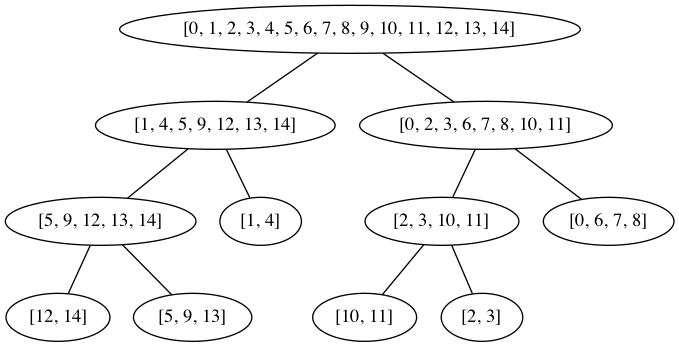

In [121]:
from IPython.display import Image
Image(filename='cart_tree.png') 

## C4.5

In C4.5 method we generate a non-binary tree. As in the previous example, we should define the Leaf.

In [122]:
class Leaf:

    def __init__(self, elements, labels, ids):
        self.child_leafs = []
        self.elements = elements
        self.labels = labels
        self.completed = False
        self.ids = ids

    def get_elements(self):
        return self.elements

    def set_child_leafs(self, new_leafs):
        self.child_leafs = new_leafs

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def get_child_leafs(self):
        return self.child_leafs

    def get_ids(self):
        return self.ids

We need ``ids`` to track the split and set the root of the tree.

In [123]:
ids = list(range(len(data_set)))
root = Leaf(data_set, labels, ids)
current_node = root

There are several helper functions that are next used by our CART method. We use the methods to:
- ``get_unique_labels`` - return the unique labels in a leaf,
- ``get_unique_values`` - return unique values in a leaf,
- ``is_leaf_completed`` - check if a leaf needs to be split or not,
- ``find_leaf_not_completed`` - returns the leaf that needs to be split,
- ``get_current_node`` - return the leaf that we should currently work on (split).

In [124]:
def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()

def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique

def is_leaf_completed(node):
    if node.is_completed():
        child_nodes = node.get_child_leafs()
        if len(child_nodes) == 0:
            return None
        is_child_to_return = False
        for i in range(len(child_nodes)):
            if not child_nodes[i].is_completed():
                return child_nodes[i]
            else:
                new_node = is_leaf_completed(child_nodes[i])
                if new_node != None:
                    is_child_to_return=True
        if is_child_to_return:
            return new_node
    return node

def find_leaf_not_completed(root_node):
    return is_leaf_completed(root_node)

def get_current_node(root):
    return find_leaf_not_completed(root)

We can calcualte the entropy: 
\begin{equation}
E(X)=-\sum_{i=1}^{m}p_{i}\log_{2}p_{i}.
\end{equation}

In [125]:
def calculate_entropy(labels):
    unique_labels, labels_count = np.unique(labels, return_counts=True)
    entropy = 0
    size = len(labels)
    for i in range(len(unique_labels)):
        if labels_count[i] > 0:
            log2 = log((labels_count[i] * 1.0) / (size * 1.0), 2)
        else:
            log2 = 0.0
        entropy = entropy - 1.0 * ((labels_count[i] * 1.0) / size) * log2
    return entropy

The method below finds the candiate to split using the entropy.

In [126]:
def calculate_split_candidate_entropy(full_entropy, labels, elements, unique_labels, unique_elements, iter):
    split_entropy = 0
    for i in range(len(unique_elements)):
        indices = np.where(np.array(elements)[..., iter].tolist() == unique_elements[i])
        unique_size = len(indices[0].tolist())
        filtered_labels = np.array(labels)[indices]
        for j in range(len(unique_labels)):
            labels_count = filtered_labels.tolist().count(unique_labels[j])
            if labels_count > 0:
                log2 = log((labels_count * 1.0) / (unique_size * 1.0), 2)
            else:
                log2 = 0.0
            split_entropy = split_entropy - 1.0 * (
                    (labels_count * 1.0) / unique_size * 1.0) * log2 * unique_size * 1.0 / len(elements) * 1.0
    return (full_entropy - split_entropy)


Split the leaf:

In [127]:
def split(current_node, split_values, column_id, split_history):
    new_leafs = []
    for i in range(len(split_values)):
        indices = np.where(np.array(current_node.get_elements())[..., column_id].tolist() == split_values[i])
        new_leaf_elements = np.array(current_node.get_elements())[indices].tolist()
        new_leaf_labels   = np.array(current_node.get_labels())[indices].tolist()
        new_leaf_ids = np.array(current_node.get_ids())[indices].tolist()
        new_leaf = Leaf(new_leaf_elements,new_leaf_labels, new_leaf_ids)
        split_history.append([str(current_node.ids), str(new_leaf_ids)])
        if len(np.unique(new_leaf_labels)) == 1:
            new_leaf.set_completed()
        new_leafs.append(new_leaf)
    current_node.set_child_leafs(new_leafs)
    current_node.set_completed()
    return current_node, split_history

Finally, we can build the tree as below:

In [128]:
def build(root):
    stop_criterion = False
    split_history = []
    current_node = root
    unique_labels = get_unique_labels(root.get_labels())
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        full_entropy = calculate_entropy(current_node.get_labels())
        max_entropy_id = 0
        max_entropy_value = 0
        for i in range(len(unique_values)):
            split_entropy = calculate_split_candidate_entropy(full_entropy,
                                                                      current_node.get_labels(),
                                                                      current_node.get_elements(),
                                                                      unique_labels,
                                                                      unique_values[i], i)
            if split_entropy > max_entropy_value:
                max_entropy_id = i
                max_entropy_value = split_entropy
        current_node, split_history = split(current_node, unique_values[max_entropy_id], max_entropy_id, split_history)
        new_node = get_current_node(root)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root, split_history

The building methods returns the same variables as in the previous example:

In [129]:
c45_tree, split_history_c45 = build(root)

It is worth to save the history.

In [130]:
%store split_history_c45

Stored 'split_history_c45' (list)
